In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, BatchNormalization, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical, pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xml.etree.ElementTree as ET
from sklearn.preprocessing import LabelEncoder
from data_augmentation import Augmenter

In [2]:
data = []

for root, subdirs, files in os.walk('dataset'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in files:
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                data.append((label, points))

In [3]:
augmenter = Augmenter(gestures=data)
training_set = augmenter.get_avc_set()

In [5]:
labels = [sample[0] for sample in training_set]

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

y = to_categorical(labels_encoded)

sequences = [sample[1] for sample in training_set]
sequences = pad_sequences(
    sequences, padding="pre", dtype='float32'
)
X = np.array(sequences)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'caret', 'arrow', 'check'}
{0, 1, 2}
3
(1228, 104, 2) (308, 104, 2) (1228, 3) (308, 3)


In [6]:
# Define the model proposed in Maslych et al.(2023)
model = Sequential()

model.add(GRU(96, dropout=0.03))

model.add(BatchNormalization())
model.add(Dropout(.3)) # input shape?
model.add(Dense(64))

model.add(BatchNormalization())
model.add(Dropout(.3))
model.add(Dense(32))

model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Dense(3))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [11]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/40
3/3 [==============================] - 1s 312ms/step - loss: 4.9851 - accuracy: 0.4430 - val_loss: 9.0080 - val_accuracy: 0.5974 - lr: 0.0010
Epoch 2/40
3/3 [==============================] - 1s 289ms/step - loss: 5.0726 - accuracy: 0.4381 - val_loss: 8.1248 - val_accuracy: 0.5877 - lr: 0.0010
Epoch 3/40
3/3 [==============================] - 1s 303ms/step - loss: 4.6586 - accuracy: 0.4023 - val_loss: 7.6547 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 4/40
3/3 [==============================] - 1s 179ms/step - loss: 5.1796 - accuracy: 0.4357 - val_loss: 7.1278 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 5/40
3/3 [==============================] - 1s 178ms/step - loss: 4.4572 - accuracy: 0.4153 - val_loss: 6.8983 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 6/40
3/3 [==============================] - 1s 181ms/step - loss: 4.8240 - accuracy: 0.4357 - val_loss: 7.0159 - val_accuracy: 0.5812 - lr: 0.0010
Epoch 7/40
3/3 [==============================] - 1s 174ms/step - loss: 4.8345 - a

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 96)                28800     
                                                                 
 batch_normalization (BatchN  (None, 96)               384       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 64)                6208      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [13]:
# Define the model
our_model = Sequential()

our_model.add(LSTM(96))

our_model.add(Dense(64, activation='relu'))
our_model.add(Dense(32, activation='relu'))

our_model.add(Dense(len(set(labels)), activation='softmax'))

our_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)
    
# Train the model
history_our_model = our_model.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/40
3/3 [==============================] - 6s 998ms/step - loss: 1.0515 - accuracy: 0.5741 - val_loss: 0.9805 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 2/40
3/3 [==============================] - 1s 403ms/step - loss: 0.9583 - accuracy: 0.7630 - val_loss: 0.8928 - val_accuracy: 0.7890 - lr: 0.0010
Epoch 3/40
3/3 [==============================] - 1s 399ms/step - loss: 0.8745 - accuracy: 0.7850 - val_loss: 0.8137 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 4/40
3/3 [==============================] - 1s 352ms/step - loss: 0.7979 - accuracy: 0.7891 - val_loss: 0.7314 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 5/40
3/3 [==============================] - 1s 378ms/step - loss: 0.7168 - accuracy: 0.7801 - val_loss: 0.6422 - val_accuracy: 0.7662 - lr: 0.0010
Epoch 6/40
3/3 [==============================] - 1s 381ms/step - loss: 0.6369 - accuracy: 0.7598 - val_loss: 0.5718 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 7/40
3/3 [==============================] - 1s 354ms/step - loss: 0.5726 - a

In [14]:
our_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 96)                38016     
                                                                 
 dense_9 (Dense)             (None, 64)                6208      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 46,403
Trainable params: 46,403
Non-trainable params: 0
_________________________________________________________________


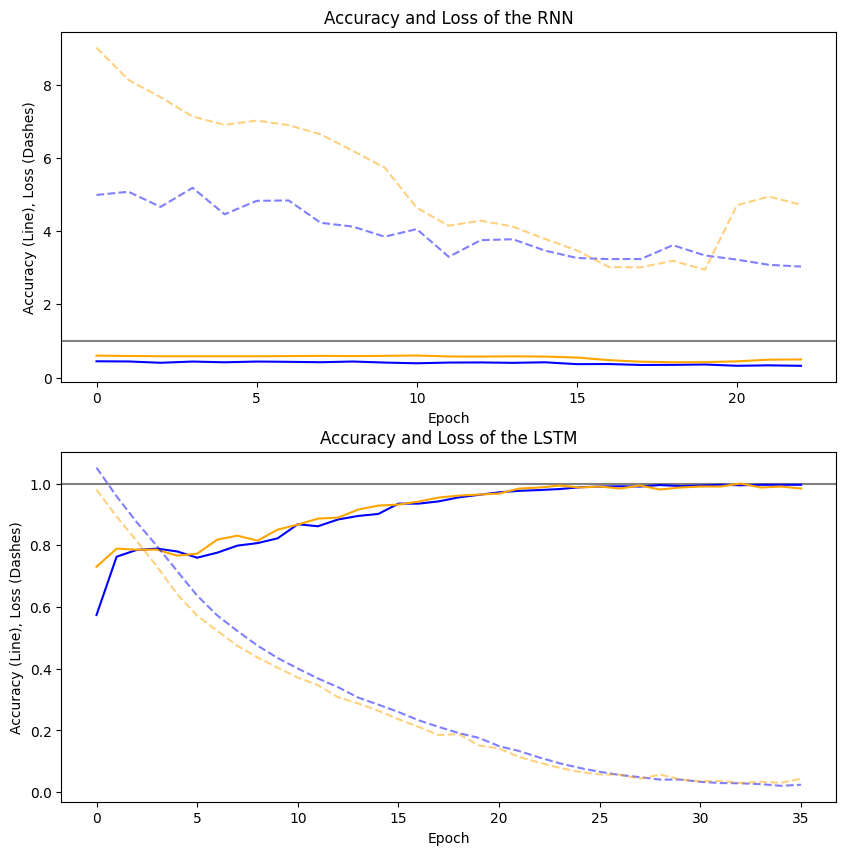

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# plot original model
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

axs[0].set_title("Accuracy and Loss of the RNN")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (Line), Loss (Dashes)')

axs[0].axhline(1, color='gray')

axs[0].plot(accuracy, color='blue')
axs[0].plot(val_accuracy, color='orange')
axs[0].plot(loss, '--', color='blue', alpha=0.5)
axs[0].plot(val_loss, '--', color='orange', alpha=0.5)


# plot the model we used
loss = history_our_model.history['loss']
val_loss = history_our_model.history['val_loss']
accuracy = history_our_model.history['accuracy']
val_accuracy = history_our_model.history['val_accuracy']

axs[1].set_title("Accuracy and Loss of the LSTM")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (Line), Loss (Dashes)')

axs[1].axhline(1, color='gray')

axs[1].plot(accuracy, color='blue')
axs[1].plot(val_accuracy, color='orange')
axs[1].plot(loss, '--', color='blue', alpha=0.5)
axs[1].plot(val_loss, '--', color='orange', alpha=0.5)

10/10 [==============================] - 0s 21ms/step


Text(0.5, 1.0, 'Confusion Matrix for the LSTM')

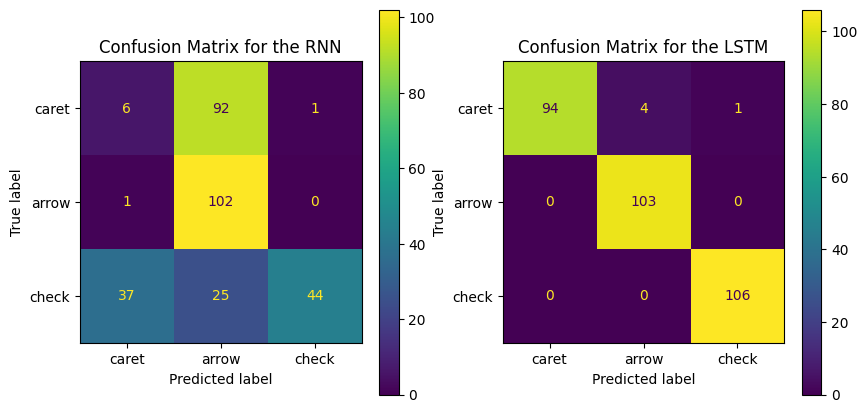

In [35]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)
y_predictions = np.argmax(y_predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

# let the model make predictions for our training data
y_predictions2 = our_model.predict(X_test)
y_predictions2 = np.argmax(y_predictions2, axis=1)
y_test_labels2 = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix2 = confusion_matrix(y_test_labels2, y_predictions2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=axs[0])
ConfusionMatrixDisplay(conf_matrix2, display_labels=set(labels)).plot(ax=axs[1])

axs[0].set_title("Confusion Matrix for the RNN")
axs[1].set_title("Confusion Matrix for the LSTM")

1/1 [==============================] - 0s 30ms/step
Label:      check
Prediction RNN: arrow
Prediction LSTM: check


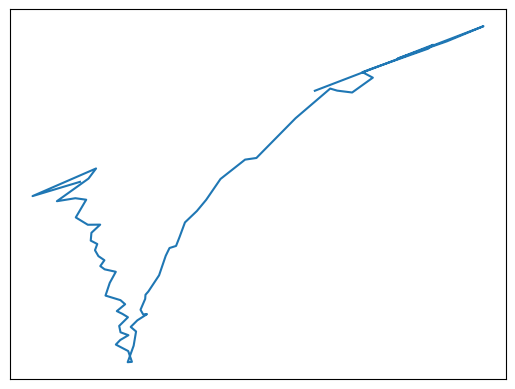

In [39]:
# lets test the model in action

test_data = random.sample(training_set, 1)[0]

label = test_data[0]
sequence = test_data[1]

plt.plot(sequence.T[0], sequence.T[1]*-1)
plt.xticks([])
plt.yticks([])

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)
prediction_lstm = our_model.predict(np.array([sequence]))
prediction_lstm = np.argmax(prediction_lstm)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]
prediction_label_lstm = encoder.inverse_transform(np.array([prediction_lstm]))[0]

print('Label:     ', label)
print('Prediction RNN:', prediction_label)
print('Prediction LSTM:', prediction_label_lstm)